In [ ]:
# -*- coding: utf-8 -*-
"""Driver Drowsiness Detection Final Project"""

import requests
from IPython.display import Image
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import opendatasets as od
from sklearn.metrics import classification_report, confusion_matrix
from google.colab.patches import cv2_imshow

# Download Dataset from Kaggle
od.download("https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset")
od.download('https://www.kaggle.com/datasets/adinishad/prediction-images')

# Defining the Image Size and Categories
IMG_SIZE = 145
categories = ["yawn", "no_yawn", "Closed", "Open"]

# Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier('./prediction-images/haarcascade_frontalface_default.xml')

# Function to preprocess and resize images
def process_image(directory, categories, face_cascade):
    data = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                faces = face_cascade.detectMultiScale(img_array, 1.3, 5)
                for (x, y, w, h) in faces:
                    roi_color = img_array[y:y + h, x:x + w]
                    resized_image = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    data.append([resized_image, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")
    return data

# Processing images
data = process_image('./drowsiness-dataset/train', categories, face_cascade)

# Preparing features and labels
X = []
y = []
for feature, label in data:
    X.append(feature)
    y.append(label)

X = np.array(X)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# One-Hot Encoding of labels
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test, shuffle=True)

# Building the CNN Model
model = Sequential()
model.add(Conv2D(512, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

# Compile Model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

# Training the Model
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Save the model
model.save("drowsiness_model.h5")

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Classification Report and Confusion Matrix
# Classification Report and Confusion Matrix
from sklearn.utils.multiclass import unique_labels

# Classification Report and Confusion Matrix
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

print(classification_report(np.argmax(y_test, axis=1), predicted_classes, target_names=categories))

cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
print("Confusion Matrix:\n", cm)



# Function to prepare and predict new images
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255.0  # Normalize image
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Testing with custom image input
def predict_image(image_path):
    prediction = model.predict([prepare(image_path)])
    prediction_label = np.argmax(prediction)
    print(f"Prediction Label: {prediction_label}")
    print(f"Prediction: {categories[prediction_label]}")

# Example Usage: Predict on a random image
predict_image("./drowsiness-dataset/train/Closed/_34.jpg")

# Visualize the model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

import visualkeras
visualkeras.layered_view(model, legend=True, draw_volume=False)


Skipping, found downloaded files in "./drowsiness-dataset" (use force=True to force download)
Skipping, found downloaded files in "./prediction-images" (use force=True to force download)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 143, 143, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 71, 71, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 69, 69, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 34, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,873,924 (18.59 MB)

 Trainable params: 4,873,924 (18.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 708ms/step - accuracy: 0.4916 - loss: 1.2214 - val_accuracy: 0.5278 - val_loss: 0.8515
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 395ms/step - accuracy: 0.5223 - loss: 0.8101 - val_accuracy: 0.4653 - val_loss: 0.7605
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.4655 - loss: 0.7549 - val_accuracy: 0.5278 - val_loss: 0.7394
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.4979 - loss: 0.7619 - val_accuracy: 0.4653 - val_loss: 0.7551
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - accuracy: 0.4919 - loss: 0.7560 - val_accuracy: 0.5278 - val_loss: 0.7377
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 381ms/step - accuracy: 0.4741 - loss: 0.7773 - val_accuracy: 0.4653 - val_loss: 0.7528
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.5174 - loss: 0.7548 - val_accuracy: 0.5278 - val_loss: 0.7399
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.5001 - loss: 0.7615 - val_accuracy: 0.4653 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8853 - loss: 0.3887
Test Loss: 0.3125261068344116
Test Accuracy: 0.9097222089767456
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mel
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset


100%|██████████| 161M/161M [00:06<00:00, 26.9MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mel
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adinishad/prediction-images


100%|██████████| 1.18M/1.18M [00:00<00:00, 2.24MB/s]


<ipython-input-7-dba3b3028f97>:74: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 338ms/step - accuracy: 0.3519 - loss: 1.9167 - val_accuracy: 0.7736 - val_loss: 0.4719
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.6703 - loss: 0.7967 - val_accuracy: 0.8161 - val_loss: 0.3926
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7197 - loss: 0.6383 - val_accuracy: 0.8241 - val_loss: 0.3487
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - accuracy: 0.7349 - loss: 0.5799 - val_accuracy: 0.8172 - val_loss: 0.3606
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.7524 - loss: 0.5091 - val_accuracy: 0.8207 - val_loss: 0.3300
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.7804 - loss: 0.4621 - val_accuracy: 0.8195 - val_loss: 0.3377
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.7662 - loss: 0.4580 - val_accuracy: 0.8310 - val_loss: 0.3141
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.7863 - loss: 0.4293 - val_accuracy: 0.831

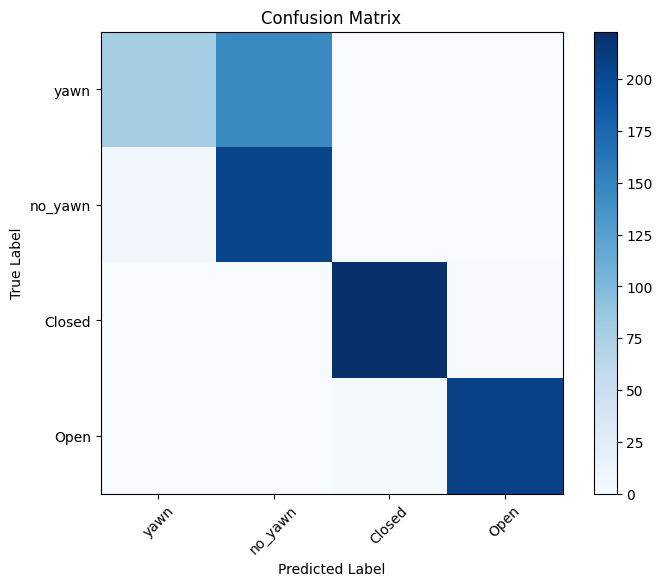

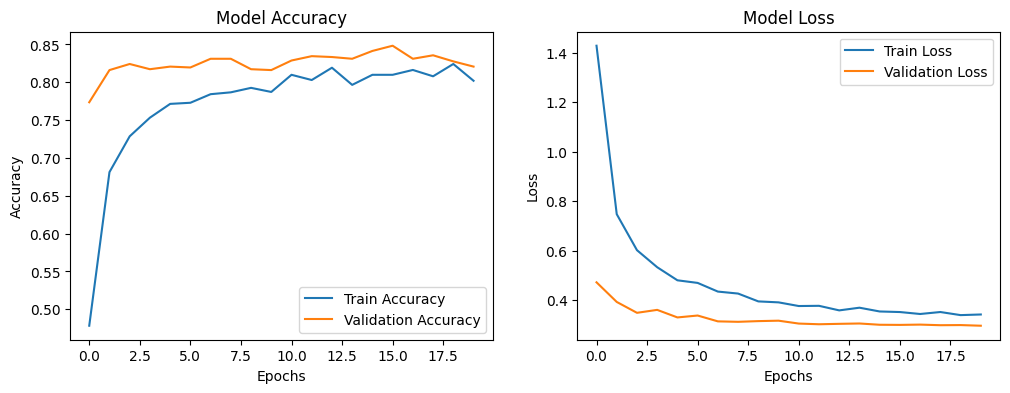

In [7]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import opendatasets as od
from sklearn.metrics import classification_report, confusion_matrix
from google.colab.patches import cv2_imshow

# Download Dataset from Kaggle
od.download("https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset")
od.download('https://www.kaggle.com/datasets/adinishad/prediction-images')
# تنظیمات اولیه
IMG_SIZE = 145
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
CATEGORIES = ["yawn", "no_yawn", "Closed", "Open"]

# پردازش تصاویر
def process_image(directory, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img = load_img(img_path, target_size=(img_size, img_size))
                img_array = img_to_array(img) / 255.0  # نرمال‌سازی تصاویر
                data.append([img_array, class_num])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return data

# بارگذاری داده‌ها
train_dir = './drowsiness-dataset/train'
data = process_image(train_dir, CATEGORIES, IMG_SIZE)

# آماده‌سازی ویژگی‌ها و برچسب‌ها
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

X = np.array(X, dtype='float32')
y = np.array(y)
y = to_categorical(y, num_classes=len(CATEGORIES))

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# تولید داده‌های افزوده‌شده
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

# استفاده از MobileNetV2 به عنوان مدل از پیش‌آموزش‌دیده
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # فریز کردن لایه‌های از پیش آموزش‌دیده

# افزودن لایه‌های بالایی
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(CATEGORIES), activation='softmax')
])

# کامپایل مدل
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# آموزش مدل
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

# ارزیابی مدل
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# پیش‌بینی و گزارش عملکرد
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

# نمایش ماتریس درهم‌ریختگی
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(np.arange(len(CATEGORIES)), CATEGORIES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# رسم نمودار دقت و خطا
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_history(history)


Skipping, found downloaded files in "./drowsiness-dataset" (use force=True to force download)


<ipython-input-9-8dbf27296e55>:89: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 295ms/step - accuracy: 0.3868 - loss: 1.7721 - val_accuracy: 0.7701 - val_loss: 0.4880
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.6779 - loss: 0.7876 - val_accuracy: 0.8080 - val_loss: 0.3812
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.7628 - loss: 0.5256 - val_accuracy: 0.8276 - val_loss: 0.3240
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.7614 - loss: 0.5199 - val_accuracy: 0.8322 - val_loss: 0.3177
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.7754 - loss: 0.4722 - val_accuracy: 0.8425 - val_loss: 0.3069
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.7720 - loss: 0.4521 - val_accuracy: 0.8425 - val_loss: 0.3101
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.7886 - loss: 0.4205 - val_accuracy: 0.8517 - val_loss: 0.3037
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.7870 - loss: 0.4149 - val_accuracy: 0.840

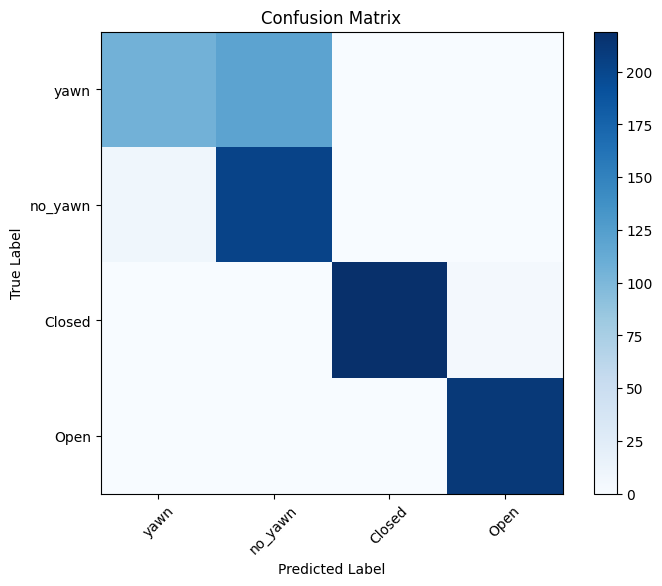

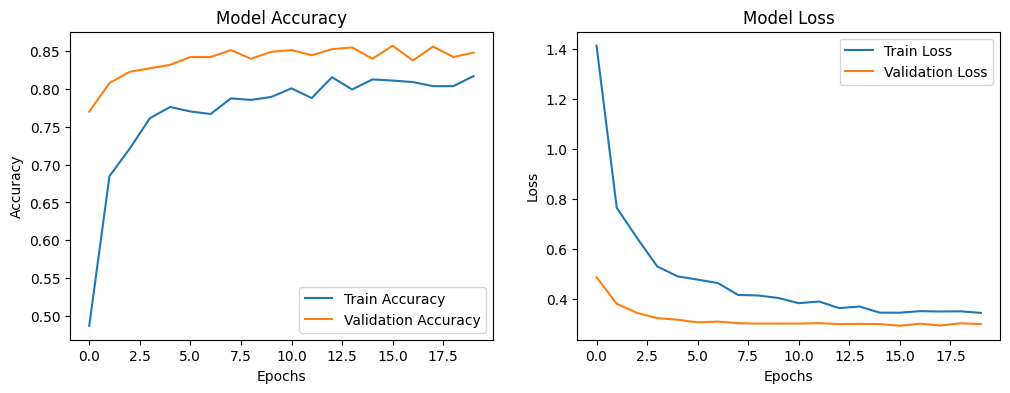

In [9]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import opendatasets as od

# Download Dataset from Kaggle
od.download("https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset")

# تنظیمات اولیه
IMG_SIZE = 145
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
CATEGORIES = ["yawn", "no_yawn", "Closed", "Open"]

# بهبود پیش‌پردازش تصویر
def preprocess_image(image_path, img_size):
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # فیلتر گوسی برای کاهش نویز
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # افزایش کنتراست با CLAHE
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # تغییر سایز تصویر و نرمال‌سازی
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# پردازش تصاویر
def process_image(directory, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = preprocess_image(img_path, img_size)
            if img is not None:
                data.append([img, class_num])
    return data

# بارگذاری داده‌ها
train_dir = './drowsiness-dataset/train'
data = process_image(train_dir, CATEGORIES, IMG_SIZE)

# آماده‌سازی ویژگی‌ها و برچسب‌ها
X, y = zip(*data)
X = np.array(X, dtype='float32')
y = to_categorical(np.array(y), num_classes=len(CATEGORIES))

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# تولید داده‌های افزوده‌شده
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

# استفاده از MobileNetV2 به عنوان مدل از پیش‌آموزش‌دیده
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# افزودن لایه‌های بالایی
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(CATEGORIES), activation='softmax')
])

# کامپایل مدل
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# آموزش مدل
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

# ارزیابی مدل
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# پیش‌بینی و گزارش عملکرد
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

# نمایش ماتریس درهم‌ریختگی
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(np.arange(len(CATEGORIES)), CATEGORIES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# رسم نمودار دقت و خطا
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_history(history)


Skipping, found downloaded files in "./drowsiness-dataset" (use force=True to force download)


<ipython-input-10-5ba997fdb201>:78: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.2779 - loss: 1.7376 - val_accuracy: 0.2632 - val_loss: 1.5876
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.2878 - loss: 1.5274 - val_accuracy: 0.2897 - val_loss: 1.6301
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.3313 - loss: 1.3997 - val_accuracy: 0.2874 - val_loss: 1.5831
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.3152 - loss: 1.3657 - val_accuracy: 0.2690 - val_loss: 1.6052
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.3256 - loss: 1.3351 - val_accuracy: 0.2678 - val_loss: 1.6364
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.3670 - loss: 1.2856 - val_accuracy: 0.2724 - val_loss: 1.6504
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.3325 - loss: 1.2929 - val_accuracy: 0.2747 - val_loss: 1.7510
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.3605 - loss: 1.2662 - val_accuracy: 0.275

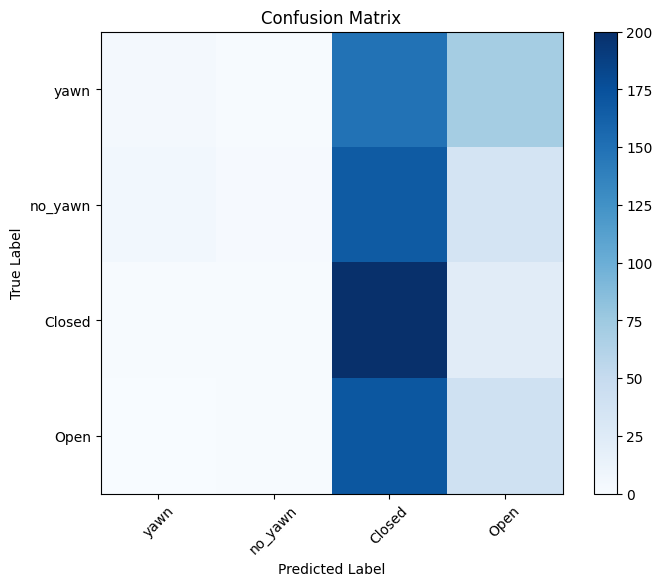

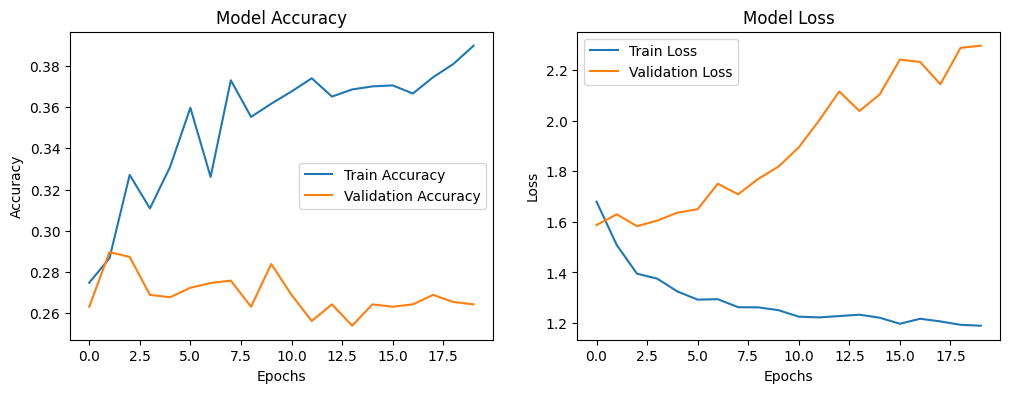

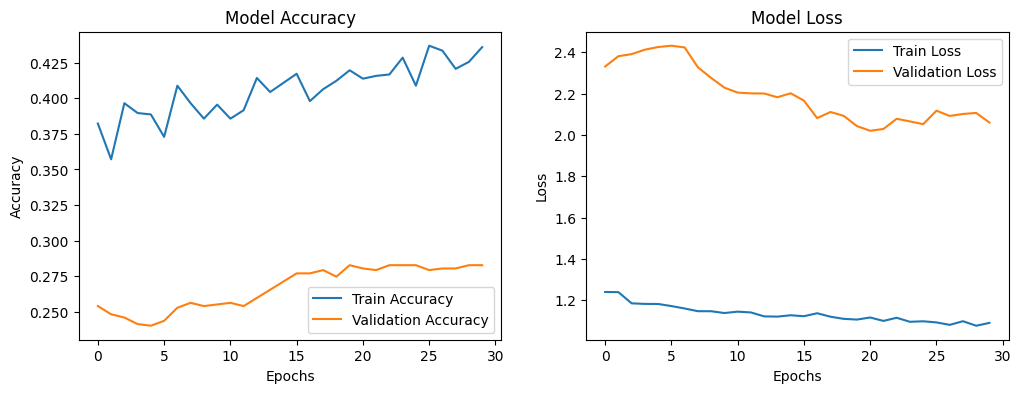

In [10]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import opendatasets as od

# Download Dataset from Kaggle
od.download("https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset")

# تنظیمات اولیه
IMG_SIZE = 145
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
CATEGORIES = ["yawn", "no_yawn", "Closed", "Open"]

# پیش‌پردازش تصویر
def preprocess_image(img_path, img_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  # تبدیل به YCbCr
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])  # افزایش کنتراست کانال روشنایی
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)  # بازگشت به RGB
    img = cv2.resize(img, (img_size, img_size))  # تغییر اندازه
    img = img / 255.0  # نرمال‌سازی
    return img

# پردازش تصاویر با پیش‌پردازش
def process_image_with_preprocessing(directory, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = preprocess_image(img_path, img_size)
                data.append([img, class_num])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return data

# بارگذاری داده‌ها
train_dir = './drowsiness-dataset/train'
data = process_image_with_preprocessing(train_dir, CATEGORIES, IMG_SIZE)

# آماده‌سازی ویژگی‌ها و برچسب‌ها
X, y = zip(*data)
X = np.array(X, dtype='float32')
y = np.array(y)
y = to_categorical(y, num_classes=len(CATEGORIES))

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# تقویت داده‌ها
train_datagen = ImageDataGenerator(
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

# استفاده از MobileNetV2 به عنوان مدل از پیش‌آموزش‌دیده
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # فریز کردن لایه‌های از پیش آموزش‌دیده

# افزودن لایه‌های بالایی
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(CATEGORIES), activation='softmax')
])

# کامپایل مدل
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# آموزش مدل
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator)

# باز کردن برخی لایه‌های انتهایی MobileNetV2
for layer in base_model.layers[-20:]:
    layer.trainable = True

# کامپایل مجدد مدل با نرخ یادگیری کمتر
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10), loss='categorical_crossentropy', metrics=['accuracy'])

# ادامه آموزش مدل
history_fine_tune = model.fit(train_generator, epochs=EPOCHS + 10, validation_data=test_generator)

# ارزیابی نهایی
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# گزارش عملکرد
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

# نمایش ماتریس درهم‌ریختگی
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(np.arange(len(CATEGORIES)), CATEGORIES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# رسم نمودار دقت و خطا
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_history(history)
plot_history(history_fine_tune)


In [ ]:
# -*- coding: utf-8 -*-
"""Driver Drowsiness Detection Final Project"""

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import opendatasets as od

# Download Dataset from Kaggle
od.download("https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset")
od.download("https://www.kaggle.com/datasets/adinishad/prediction-images")

# Defining the Image Size and Categories
IMG_SIZE = 145
categories = ["yawn", "no_yawn", "Closed", "Open"]

# Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier('./prediction-images/haarcascade_frontalface_default.xml')

def process_image(directory, categories, face_cascade):
    data = []
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

                # Face detection with Haar Cascade
                faces = face_cascade.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=5)
                for (x, y, w, h) in faces:
                    roi_color = img_array[y:y + h, x:x + w]

                    # Resize to required dimensions
                    resized_image = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))

                    # Normalize to 0-1 range
                    normalized_image = resized_image / 255.0

                    data.append([normalized_image, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")
    return data

# Processing images
data = process_image('./drowsiness-dataset/train', categories, face_cascade)

# Preparing features and labels
X = []
y = []
for feature, label in data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# One-Hot Encoding of labels
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test, shuffle=True)

# Building the CNN Model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation="softmax"))

# Compile Model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.summary()

# Training the Model
history = model.fit(train_generator, epochs=30, validation_data=test_generator)

# Save the model
model.save("drowsiness_model.h5")

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate Predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate Classification Report
filtered_categories = [categories[i] for i in np.unique(np.argmax(y_test, axis=1))]
print(classification_report(np.argmax(y_test, axis=1), predicted_classes, target_names=filtered_categories))

# Generate Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
print("Confusion Matrix:\n", cm)

# Function to prepare and predict new images
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255.0  # Normalize image
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

def predict_image(image_path):
    prediction = model.predict(prepare(image_path))
    prediction_label = np.argmax(prediction)
    print(f"Prediction Label: {prediction_label}")
    print(f"Prediction: {categories[prediction_label]}")

# Example Usage: Predict on a random image
predict_image("./drowsiness-dataset/train/Closed/_34.jpg")


Skipping, found downloaded files in "./drowsiness-dataset" (use force=True to force download)
Skipping, found downloaded files in "./prediction-images" (use force=True to force download)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 143, 143, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 71, 71, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 69, 69, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 147968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      18,940,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,016,196 (72.54 MB)

 Trainable params: 19,016,196 (72.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 917ms/step - accuracy: 0.4369 - loss: 1.3583 - val_accuracy: 0.5278 - val_loss: 1.1421
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4715 - loss: 1.0526 - val_accuracy: 0.5278 - val_loss: 0.7627
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.4521 - loss: 0.8278 - val_accuracy: 0.4653 - val_loss: 0.7351
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5357 - loss: 0.7617 - val_accuracy: 0.5278 - val_loss: 0.7309
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.4794 - loss: 0.8288 - val_accuracy: 0.5278 - val_loss: 0.7397
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5423 - loss: 0.8212 - val_accuracy: 0.5278 - val_loss: 0.7361
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.5445 - loss: 0.7766 - val_accuracy: 0.5278 - val_loss: 0.7336
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.5367 - loss: 0.7487 - val_accuracy: 0.5278 - val_loss

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7242 - loss: 0.6887
Test Loss: 0.6251264214515686
Test Accuracy: 0.7430555820465088
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
              precision    recall  f1-score   support

        yawn       0.00      0.00      0.00        76
     no_yawn       0.47      1.00      0.64        67
      Closed       0.00      0.00      0.00         1

    accuracy                           0.47       144
   macro avg       0.16      0.33      0.21       144
weighted avg       0.22      0.47      0.30       144

Confusion Matrix:
 [[ 0 76  0]
 [ 0 67  0]
 [ 0  1  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
Prediction Label: 1
Prediction: no_yawn


In [6]:
!pip install opendatasets
